In this Jupyter, I'll try to come up with a nice solution to increase the IoU. I'll use a silly RGB classifier and try to draw the classifications squares around the colored pixels.
I found some stuff in the internet, but didn't seem exactly what we needed. So... Let's go!

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
from pathlib import Path
from PIL import Image

plt.rcParams["figure.figsize"] = (15, 15)

### Silly 8000x8000 RGB image... Objective: classify small windows of 256x256 having R, G or B within it.

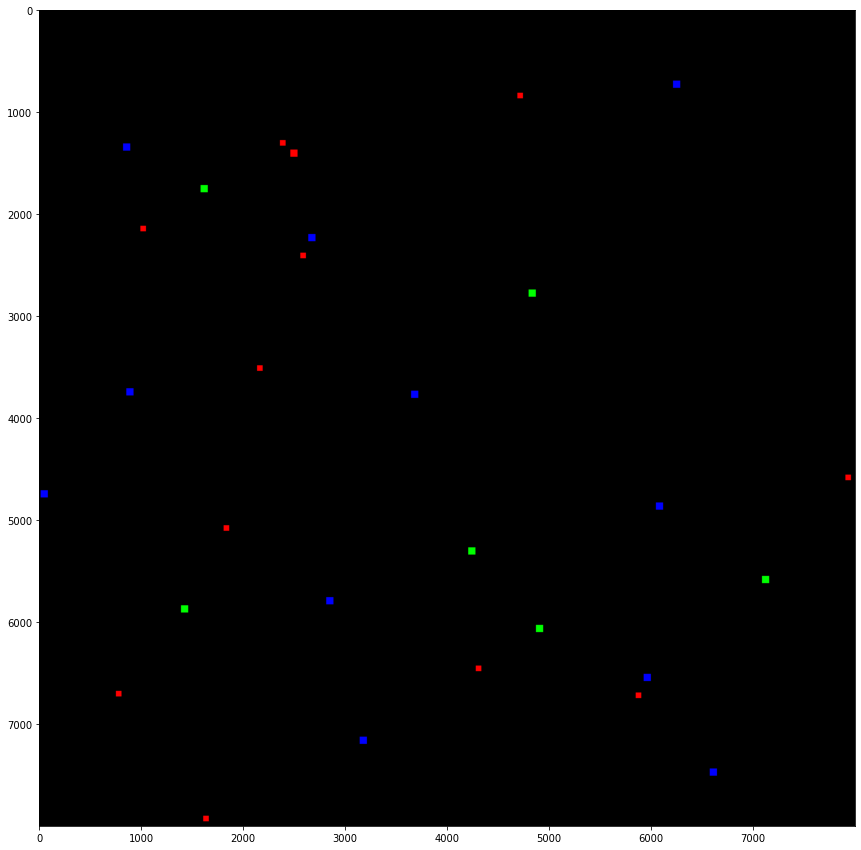

In [93]:
img_path = Path('../../../mnt/c/Users/dimit/Downloads/rgb_detection_test.png')
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

### Silly classifier

The usage of generators will be very important for memory usage!!! Never forget yield!!!

-1 means nothing

0 means red

1 means green

2 means blue

In [194]:
class Classifier():
    def _predict_single_img(self, img):
        for channel in range(3):
            if np.sum(img[:, :, channel]) > 255*50*50:
                return channel
        return -1
        
    def predict(self, X):
        for img in X:
            yield self._predict_single_img(img)

In [195]:
def sliding_window(img, size=256, step=128):
    for i in np.arange(0, img.shape[0], step):
        for j in np.arange(0, img.shape[1], step):
            x_min = i 
            x_max = i + size
            y_min = j
            y_max = j + size
            if x_max > img.shape[0]:
                x_max = img.shape[0] - 1
                x_min = x_max - size 
            if y_max > img.shape[1]:
                y_max = img.shape[1] - 1
                y_min = y_max - size 
            yield img[x_min:x_max, y_min:y_max, :].copy()

### Using the classifier to predict R, G and B within the small windows

In [230]:
size = 256
step = int(0.25*256)

img_windows = sliding_window(img, size, step)
cls = Classifier()
preds = list(cls.predict(img_windows)).copy()
np.unique(preds, return_counts=True)

(array([-1,  0,  1,  2]), array([15225,   151,    95,   154]))

### Drawing the classifications

In [231]:
i_pred      = -1
coordinates = []

# for each sliding window
for i in np.arange(0, img.shape[0], step):
    for j in np.arange(0, img.shape[1], step):
        
        # if there is something in this window...
        i_pred += 1
        if preds[i_pred] >= 0:
            
            # set coordinates
            x_min = i 
            x_max = i + size
            y_min = j
            y_max = j + size
            if x_max > img.shape[0]:
                x_max = img.shape[0] - 1
                x_min = x_max - size 
            if y_max > img.shape[1]:
                y_max = img.shape[1] - 1
                y_min = y_max - size
            
            # save coordinates and prediction
            coordinates.append([x_min, x_max, y_min, y_max, preds[i_pred]])

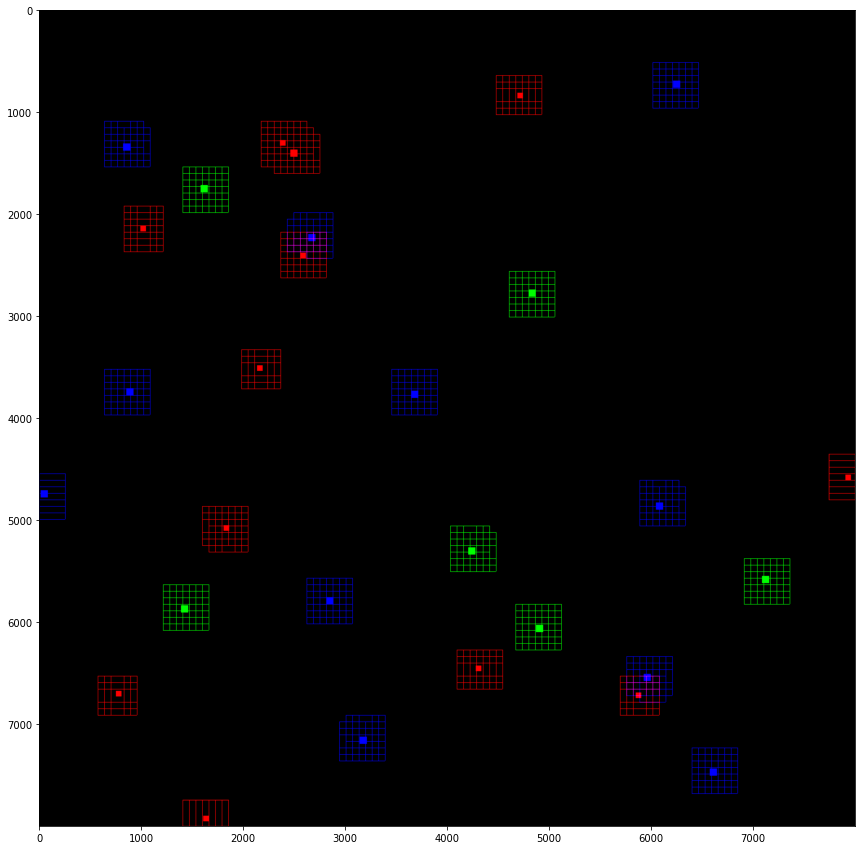

In [232]:
img_first_classifications = img.copy()

for x_min, x_max, y_min, y_max, pred in coordinates:
    img_first_classifications[x_min:x_max, y_min:y_min+5, pred] = 255
    img_first_classifications[x_min:x_max, y_max:y_max+5, pred] = 255
    img_first_classifications[x_min:x_min+5, y_min:y_max, pred] = 255
    img_first_classifications[x_max:x_max+5, y_min:y_max, pred] = 255

plt.imshow(img_first_classifications)
plt.show()

### Finding the intersection

for the third consecutive classification, there is no overlapping to the first. So, I need to increase the coordinates a bit in order to find some intersections.

In [233]:
def check_intersection(a, b, increase):
    def increase_size(a, increase):
        return [
            a[0] - increase, # x_min
            a[1] + increase, # x_max
            a[2] - increase, # y_min
            a[3] + increase, # y_max
            a[4]             # label
        ]
    
    a = increase_size(a, increase)
    b = increase_size(b, increase)
    
    if b[0] > a[1]:
        return None
    if b[2] > a[3]:
        return None
    if b[1] < a[0]:
        return None
    if b[3] < a[2]:
        return None
    
    x_min = max(a[0], b[0])
    x_max = min(a[1], b[1])
    y_min = max(a[2], b[2])
    y_max = min(a[3], b[3])
    
    return [x_min, x_max, y_min, y_max, a[-1]]
    

increase        = int(step/20)
ignore_idxs     = []
new_coordinates = []

for i in range(len(coordinates)):
    
    if i in ignore_idxs:
        continue
        
    final_coordinates = coordinates[i]
    
    for j in range(i+1, len(coordinates)):
        
        if j in ignore_idxs:
            continue
            
        if final_coordinates[-1] != coordinates[j][-1]:
            continue
            
        inter_coordinates = check_intersection(final_coordinates, coordinates[j], increase)
        if inter_coordinates is not None:
            final_coordinates = inter_coordinates
            ignore_idxs.append(j)
            
    new_coordinates.append(final_coordinates)

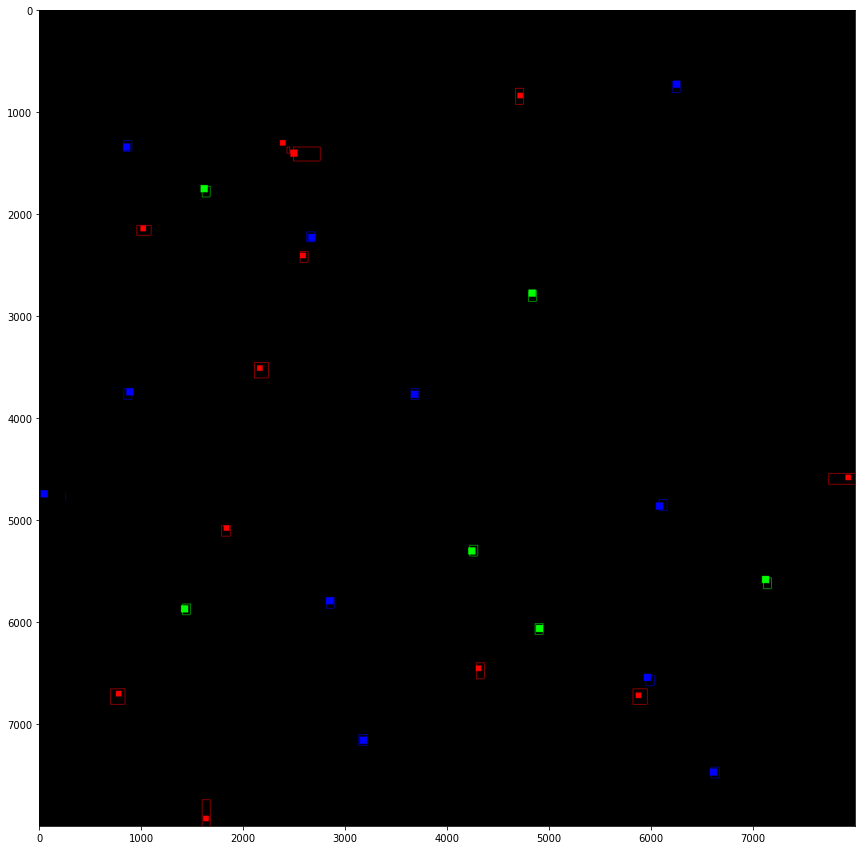

In [234]:
img_final_classifications = img.copy()

for x_min, x_max, y_min, y_max, pred in new_coordinates:
    img_final_classifications[x_min:x_max, y_min:y_min+5, pred] = 255
    img_final_classifications[x_min:x_max, y_max:y_max+5, pred] = 255
    img_final_classifications[x_min:x_min+5, y_min:y_max, pred] = 255
    img_final_classifications[x_max:x_max+5, y_min:y_max, pred] = 255

plt.imshow(img_final_classifications)
plt.show()